In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.sparse import hstack
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("cleaned_dataset_10000.csv")

In [5]:
df = df.dropna(subset=['Bot_label'])

# Fill missing metadata features with 0
metadata_features = ['user_followers', 'user_friends', 'user_favourites', 'hashtag_count']
df[metadata_features] = df[metadata_features].fillna(0)

In [6]:
unique_users = df['user_name'].unique()
train_users, test_users = train_test_split(unique_users, test_size=0.2, random_state=42)

train_df = df[df['user_name'].isin(train_users)].reset_index(drop=True)
test_df = df[df['user_name'].isin(test_users)].reset_index(drop=True)

print(f"Train samples: {len(train_df)}, Test samples: {len(test_df)}")
print(f"Common users in train and test sets: {set(train_users).intersection(set(test_users))}") 

Train samples: 7805, Test samples: 2255
Common users in train and test sets: set()


In [7]:
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),  # unigrams + bigrams
    min_df=3,
    max_df=0.9
)
X_train_text = train_df['cleaned_text'].astype(str)
X_test_text = test_df['cleaned_text'].astype(str)

X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)


In [8]:
scaler = StandardScaler()
X_train_meta = scaler.fit_transform(train_df[metadata_features])
X_test_meta = scaler.transform(test_df[metadata_features])

# Combine sparse TF-IDF and dense metadata features
X_train_combined = hstack([X_train_tfidf, X_train_meta])
X_test_combined = hstack([X_test_tfidf, X_test_meta])

# Labels
y_train = train_df['Bot_label'].astype(int)
y_test = test_df['Bot_label'].astype(int)


In [9]:
log_reg = LogisticRegression(max_iter=1000)
param_grid = {
    'C': [1, 2, 3],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # supports both l1 and l2
}

grid = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_combined, y_train)

best_model = grid.best_estimator_


In [10]:
y_train_pred = best_model.predict(X_train_combined)
y_test_pred = best_model.predict(X_test_combined)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("Best Parameters:", grid.best_params_)
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}\n")

print("Classification Report (Test Set):\n")
print(classification_report(y_test, y_test_pred))

Best Parameters: {'C': 2, 'penalty': 'l1', 'solver': 'liblinear'}
Training Accuracy: 0.9883
Test Accuracy: 0.9743

Classification Report (Test Set):

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       963
           1       0.97      0.99      0.98      1292

    accuracy                           0.97      2255
   macro avg       0.98      0.97      0.97      2255
weighted avg       0.97      0.97      0.97      2255



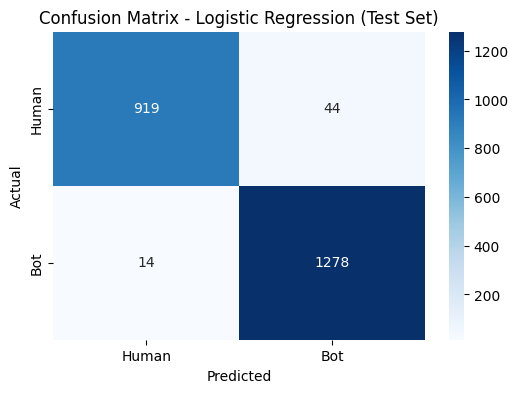

In [11]:
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Human', 'Bot'], yticklabels=['Human', 'Bot'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression (Test Set)')
plt.show()